In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

2024-08-15 13:26:33.982418: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 13:26:33.982592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 13:26:34.154944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Paths to TFRecord files
monet_tfrec_dir = '/kaggle/input/gan-getting-started/monet_tfrec/'
photo_tfrec_dir = '/kaggle/input/gan-getting-started/photo_tfrec/'

In [4]:
# Function to parse TFRecord
def parse_tfrecord_fn(example):
    feature_description = {
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

In [5]:
# Load Monet TFRecord dataset
monet_tfrecord_files = [os.path.join(monet_tfrec_dir, f) for f in os.listdir(monet_tfrec_dir)]
monet_dataset = tf.data.TFRecordDataset(monet_tfrecord_files)
monet_dataset = monet_dataset.map(parse_tfrecord_fn)

In [6]:
# Load Photo TFRecord dataset
photo_tfrecord_files = [os.path.join(photo_tfrec_dir, f) for f in os.listdir(photo_tfrec_dir)]
photo_dataset = tf.data.TFRecordDataset(photo_tfrecord_files)
photo_dataset = photo_dataset.map(parse_tfrecord_fn)

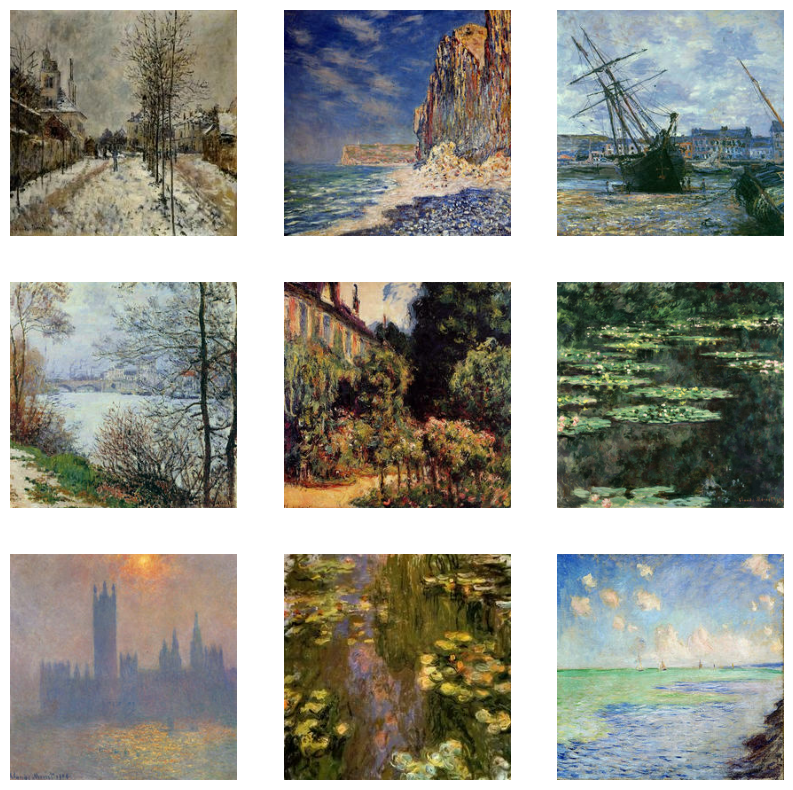

In [7]:
# Example: Display some Monet images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, image in enumerate(monet_dataset.take(9)):
    plt.subplot(3, 3, i+1)
    plt.imshow((image.numpy() + 1) / 2)  # Rescale back to [0, 1] for display
    plt.axis('off')
plt.show()

In [8]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result

In [9]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [10]:
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
# Define the loss function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define the generator loss
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    return gan_loss

In [12]:
# Instantiate the models
generator = Generator()

In [13]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [14]:
# Define the loss function (e.g., L1 loss)
loss_object = tf.keras.losses.MeanAbsoluteError()

# Compile the generator with the chosen loss and optimizer
generator.compile(optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5), loss=loss_object)

In [15]:
# Batch the datasets
BATCH_SIZE = 1 
photo_dataset = photo_dataset.batch(BATCH_SIZE)
monet_dataset = monet_dataset.batch(BATCH_SIZE)

In [16]:
def train_step(photo, monet):
    with tf.GradientTape() as tape:
        generated_monet = generator(photo, training=True)
        loss = loss_object(monet, generated_monet)
    
    gradients = tape.gradient(loss, generator.trainable_variables)
    generator.optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    return loss

In [17]:
def train(photo_dataset, monet_dataset, epochs):
    for epoch in range(epochs):
        for photo_batch, monet_batch in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
            loss = train_step(photo_batch, monet_batch)
        print(f'Epoch {epoch+1}, Loss: {loss.numpy()}')

In [18]:
train(photo_dataset, monet_dataset, epochs=15)

Epoch 1, Loss: 0.45238253474235535
Epoch 2, Loss: 0.4489462375640869
Epoch 3, Loss: 0.44900521636009216
Epoch 4, Loss: 0.4479670822620392
Epoch 5, Loss: 0.4452781081199646
Epoch 6, Loss: 0.44723016023635864
Epoch 7, Loss: 0.44697263836860657
Epoch 8, Loss: 0.4471089839935303
Epoch 9, Loss: 0.4474543333053589
Epoch 10, Loss: 0.44508352875709534
Epoch 11, Loss: 0.44320547580718994
Epoch 12, Loss: 0.44552674889564514
Epoch 13, Loss: 0.4439794421195984
Epoch 14, Loss: 0.4422072172164917
Epoch 15, Loss: 0.45034563541412354


In [19]:
from PIL import Image
import zipfile

In [20]:
# Define the output zip file
output_zip = '/kaggle/working/images.zip'

# Create a ZipFile object
with zipfile.ZipFile(output_zip, 'w') as zipf:
    for i, photo in enumerate(photo_dataset.take(10000)):  # Generate up to 10,000 images
        generated_image = generator(photo, training=False)[0]  # Generate the image
        generated_image = (generated_image.numpy() + 1) * 127.5  # Rescale from [-1, 1] to [0, 255]
        generated_image = np.clip(generated_image, 0, 255).astype(np.uint8)  # Clip values to [0, 255]

        # Convert to Image and save to the zip file
        img = Image.fromarray(generated_image)
        img_name = f'generated_monet_{i}.jpg'
        
        # Save image to the zip file
        with zipf.open(img_name, 'w') as img_file:
            img.save(img_file, format='JPEG')

        # Print progress
        if (i + 1) % 1000 == 0:
            print(f"{i+1} images processed...")

print(f"All images have been generated and saved to {output_zip}")

1000 images processed...
2000 images processed...
3000 images processed...
4000 images processed...
5000 images processed...
6000 images processed...
7000 images processed...
All images have been generated and saved to /kaggle/working/images.zip
